In [44]:
import skvideo.io
import skvideo.datasets
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Прочитаем видео из датасета, покажем начальное и конечное изображение

In [2]:
videodata = skvideo.io.vread(skvideo.datasets.bigbuckbunny())

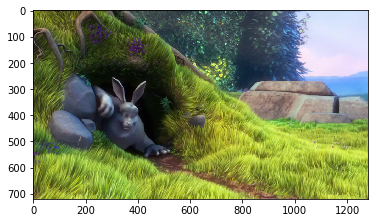

In [3]:
plt.imshow(videodata[0])

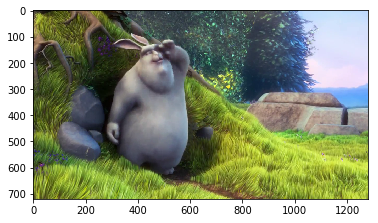

In [4]:
plt.imshow(videodata[-1])

# Гистограммы

Построим гистрграммы этих кадров и соседних с ними

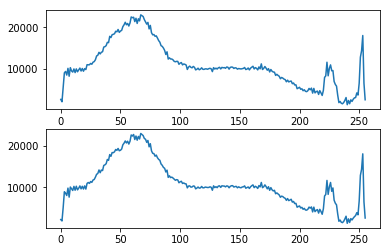

In [5]:
from funcs import hist

plt.subplot(2, 1, 1)
plt.plot(hist(videodata[0]))
plt.subplot(2, 1, 2)
plt.plot(hist(videodata[1]))

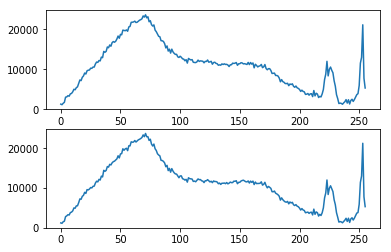

In [6]:
plt.subplot(2, 1, 1)
plt.plot(hist(videodata[-1]))
plt.subplot(2, 1, 2)
plt.plot(hist(videodata[-2]))

Видим разные гистограммы. Построим график расстояния (евклидово, возможно есть лучший выбор) между ними и гистограммой первого кадра:

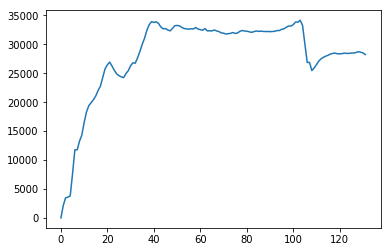

In [7]:
from sklearn.metrics import euclidean_distances

histograms = np.array([
    hist(frame)
    for frame in videodata
])
histograms_distances = euclidean_distances(histograms)[0, :]
plt.plot(histograms_distances)

Введём такую функцию расстояния, что её значения находятся в диапазоне  [0:1]

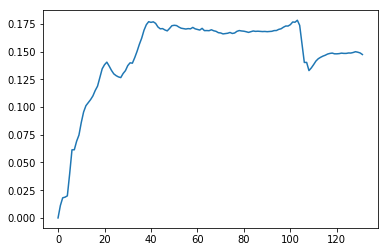

In [8]:
from funcs import hist_dissimilarity

plt.plot([
    hist_dissimilarity(histograms[0], histograms[i])
    for i in range(0, 132)
])

# P-Hash

Теперь введём функции:

* "хеширования" изображения phash - которая сопоставит булево значение каждому прямоугольному участку изображения
* "расстояния" между хешами (вычисляется как число различных значений)

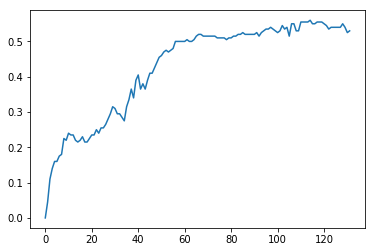

In [9]:
from funcs import phash, phash_dissimilarity

phashes = np.array([
    phash(frame)
    for frame in videodata
])
plt.plot([
    phash_dissimilarity(phashes[0], phashes[i])
    for i in range(0, 132)
])

# Поиск

Индексатор пройдётся по записи и вернёт 2 объекта:
* индексы гистограмм - номера кадров, для которых гистограммы сильно отличились от прошлых гистограмм - и усреднённые гистограммы до следующего разрыва
* индексы хешей - номера кадров, для которых гистограммы сильно отличились от прошлых гистограмм - и усреднённые гистограммы до следующего разрыва

In [10]:
from indexer import VideoIndexer

hist_index, phash_index = VideoIndexer("outputvideo.mp4", videodata).index()

Поиск сработает таким образом:
* посчитает гистограмму и phash изображения
* отберёт N отрывков, в которых phash близок к переданному, обработает в порядке близости:
    * для каждого отрывка подберёт ближайшие отрывки в индексе гистограмм
    * отсортирует их по близости гистограммы
    * добавит полученный список к результату

Попробуем найти последнее изображение из ролика

In [25]:
from search import search

image = videodata[-1]
search_result = search(image, phash_index, hist_index)[:4]
search_result

[('outputvideo.mp4', 130),
 ('outputvideo.mp4', 118),
 ('outputvideo.mp4', 112),
 ('outputvideo.mp4', 110)]

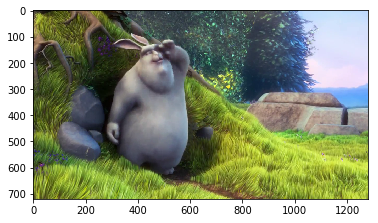

In [26]:
plt.imshow(image)

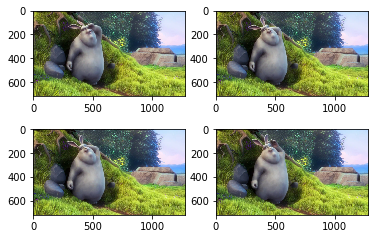

In [27]:
for i, index in enumerate(search_result):
    fname, frame = index
    plt.subplot(2, 2, i + 1)
    plt.imshow(videodata[frame])

Затемним последнее изображение, добавим шума и попробуем его найти

In [28]:
darker = 0.8
noise = np.random.rand(*image.shape) * 40
image = (videodata[-1] * darker + noise).astype(np.uint8)
search_result = search(image, phash_index, hist_index)[:4]
search_result

[('outputvideo.mp4', 130),
 ('outputvideo.mp4', 118),
 ('outputvideo.mp4', 112),
 ('outputvideo.mp4', 110)]

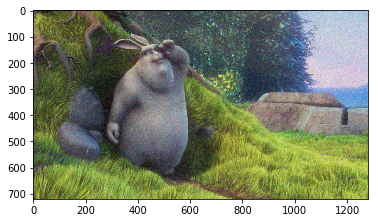

In [29]:
plt.imshow(image)

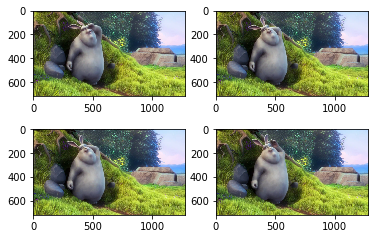

In [30]:
for i, index in enumerate(search_result):
    fname, frame = index
    plt.subplot(2, 2, i + 1)
    plt.imshow(videodata[frame])

Изменим размер изображения (нарушив пропорции)

In [41]:
from scipy.misc import imresize

image = imresize(videodata[-1], (100, 100))
darker = 0.8
noise = np.random.rand(*image.shape) * 40
image = (image * darker + noise).astype(np.uint8)
search_result = search(image, phash_index, hist_index)[:4]
search_result

[('outputvideo.mp4', 118),
 ('outputvideo.mp4', 130),
 ('outputvideo.mp4', 110),
 ('outputvideo.mp4', 112)]

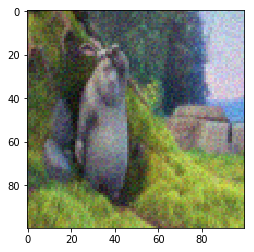

In [42]:
plt.imshow(image)

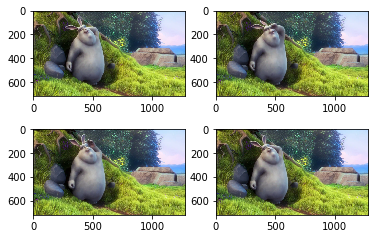

In [43]:
for i, index in enumerate(search_result):
    fname, frame = index
    plt.subplot(2, 2, i + 1)
    plt.imshow(videodata[frame])